# Notional Example Problem

An analytic problem for understanding resilience optimization structures.

In [330]:
import sys
sys.path.append('../')
import numpy as np
import scipy as sp
import time
import itertools
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

This problem considers different architectures to structure the optimization of resilience. In general, the resilience of a system is a function of the performance curve which results from a given hazardous scenario. Consider, for example, the curve shown below, where a fault causes the system to perform in a worse condition (given by $x_a$) for a given amount of time $x_b$, before it is recovered over a given amount of time $x_c$.

<h3 align="center">System Resilience to Considered Fault Scenario</h3> 

![Resilience of the System to Fault](notionalsystem.png)

In an integrated resilience optimization formulation of this problem, the goal is to optimize the design/operations of the system with the resilience variables simultaneously to balance the resilience of the system with design/operational considerations. This involves (at least) two models of cost: design/operational cost and resilience cost.

## Design/Operational Cost

The design model specifies the inherent resilience in the system that results from the way it was designed/is operated when there is no hazardous scenario. In this model, the variables are $x_p$, the overall performance of the system, $x_a$, the lost performance during the scenario, $x_s$, the slack in the system, and $x_r$, the hazard rate. The terms a-f and n are constants.

In [331]:
xdes = [1,1,1,0]
xdb = ((1e-6,100),(1e-6,100),(1e-6,100),(1e-6,100))
# xdes = [x_p, x_a, x_r, x_s]
# index:   0    1    2    3
# constants: [a,b,c,n,d,e,f]
# inds:       0,1,2,3,4,5,6
const =[1e6,1e5,1e4,10,1e5,200,500]

The Design/Operational cost model for this system is: $C_D = a*(x_p-1)^2 +b*x_s^2 + \frac{c}{\sqrt{x_r}}$ 

The terms in the cost model captures the value of having increased performance, the waste of running the system with excess slack, and the cost of maintaining the system at a certain level of reliability.

In [332]:
def des_cost(xdes,const):
    return const[0]*(xdes[0]-1)**2 + const[1]*xdes[3]**2 + const[2]/np.sqrt(max(xdes[2],1e-6))

Subject to the equality constraint: $h_D = x_p -(x_s + x_a) = 0$, which captures the relationship between slack, performance, and lost performance during the scenario.

In [333]:
def des_h_const(xdes):
    return xdes[0]-(xdes[3]+xdes[1])

There is also an inequality constraint: $g_D = 10^{-x_a} - x_r$, which specifies a lower bound on how reliable the system can be when it is running with a certain amount of slack (in the specified relationship, high slack makes the system less reliable).

In [334]:
def des_g_const(xdes):
    return np.power(10.0, -xdes[1]) - xdes[2]

## Resilience Model

The resilience model specifies how the system performes in the hazardous scenario(s) based on variables which may be leveraged during this scenario. In this system, there are two variables--$x_b$, the length of time the system stays in the hazardous scenario before it is repaired, and $x_c$, the length of time it takes to repair the system.

In [335]:
xres = [1,  1]
#ind:   0   1
#full:  4   5
#lab:   x_b,x_c
xrb = ((1e-6,100), (1e-6,100))

In this system, the resilience model is specified with a cost function:

$C_R = x_r*n*(d*x_a*(x_b+x_c/2) + e/x_c + f/x_b))$

which considers the cost as a function of the area between the nominal performance and the resilience curve (the cost of the hazard's direct consequences), along with a cost of short recovery time and a cost of short repair time (the cost of restoring the system to nominal performance at a certain speed).

In [336]:
def res_cost(xres,xdes,const):
    return xdes[2] * const[3] * (const[4]*xdes[1]*((xres[0]+xres[1]/2) + const[5]/max(xres[1],1e-6))+const[6]/max(xres[0],1e-6))

## Optimization Architectures

This problem can be solved using a number of solution architectures. This section presents and compares the all-at-once, bilevel, and alternating optimization structures.


<h3 align="center">All-at-once Architecture</h3> 

![All-at-once Architecture](allatonce.png)

The all-at-once architecture is an optimization strategy where the entire problem is solved in a single *monolithic* formulation, with the overall objective $C = C_D + C_R$

In [337]:
def x_to_totcost_mono(x, const):
    return des_cost(x, const) + res_cost(x[4:],x, const)

In [338]:
#used to keep track of optimization progress
history = []
def callbackF(Xdes, result):
    history.append(result['fun'])

Below, the trust-region constrained algorithm is used to optimize this problem. As implemented, the algorithm does not reach a convergence criteria and instead finishes after reaching the maximum number of steps (1000)

In [339]:
# all-in-one 
x = xdes + xres
xb = xdb + xrb
history = []
starttime = time.time()
constraints = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1]), 'jac': lambda x: np.array([1,-1,0,-1,0,0])}, {'type':'ineq', 'fun': lambda x: np.power(10.0, -x[1]) - x[2], 'jac': lambda x: np.array([0, -np.log(10)*np.power(10.0, -x[1]), -1, 0,0,0]) }]
result_aao = minimize(x_to_totcost_mono, x, method='trust-constr', bounds = xb, constraints =constraints, args = const, callback=callbackF, options={'maxiter':1e4, 'verbose':2})
time_aao = time.time() - starttime
aao_history = history

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   7   |   0   | +2.0152e+08 | 1.00e+00 | 1.38e+08 | 9.00e-01 |
|   2   |  14   |   1   | +9.8300e+07 | 2.00e+00 | 5.58e+07 | 6.54e-01 |
|   3   |  21   |   6   | +4.3332e+07 | 6.03e+00 | 2.10e+07 | 3.09e-01 |
|   4   |  28   |  11   | +1.2250e+07 | 6.71e+00 | 5.25e+06 | 5.21e-04 |
|   5   |  35   |  16   | +2.6611e+06 | 7.25e+00 | 9.98e+05 | 3.38e-05 |
|   6   |  42   |  21   | +6.1915e+05 | 7.25e+00 | 1.33e+05 | 1.11e-16 |
|   7   |  49   |  26   | +5.3005e+05 | 7.25e+00 | 7.20e+04 | 1.11e-16 |
|   8   |  56   |  31   | +5.1877e+05 | 7.25e+00 | 8.45e+04 | 7.77e-15 |
|   9   |  63   |  36   | +5.0108e+05 | 7.25e+00 | 7.49e+04 | 2.22e-16 |
|  10   |  70   |  41   | +4.5104e+05 | 7.25e+00 | 6.86e+04 | 8.88e-16 |
|  11   |  84   |  46   | +4.5104e+05 | 7.25e-01 | 6.86e+04 | 8.88e-16 |
|  12   |  91   |  51   | +4.4500e+05 | 9.14e-01 | 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  48   |  343  |  206  | +1.1219e+05 | 7.05e+00 | 1.81e+03 | 5.55e-16 |
|  49   |  350  |  210  | +1.1202e+05 | 7.05e+00 | 1.80e+03 | 4.44e-16 |
|  50   |  357  |  214  | +1.1186e+05 | 7.05e+00 | 1.79e+03 | 2.22e-16 |
|  51   |  364  |  218  | +1.1170e+05 | 7.05e+00 | 1.78e+03 | 6.66e-16 |
|  52   |  371  |  222  | +1.1156e+05 | 7.05e+00 | 1.78e+03 | 5.55e-16 |
|  53   |  378  |  226  | +1.1142e+05 | 7.05e+00 | 1.77e+03 | 6.66e-16 |
|  54   |  385  |  230  | +1.1128e+05 | 7.05e+00 | 1.75e+03 | 4.44e-16 |
|  55   |  392  |  234  | +1.1114e+05 | 7.05e+00 | 1.74e+03 | 8.88e-16 |
|  56   |  399  |  238  | +1.1099e+05 | 7.05e+00 | 1.73e+03 | 1.44e-15 |
|  57   |  406  |  242  | +1.1080e+05 | 7.05e+00 | 1.70e+03 | 2.22e-15 |
|  58   |  413  |  246  | +1.1050e+05 | 7.05e+00 | 1.66e+03 | 7.77e-16 |
|  59   |  420  |  250  | +1.1016e+05 | 7.05e+00 | 1.60e+03 | 2.33e-15 |
|  60   |  427  |  254  | +1.0987e+05 | 7.05e+00 | 1.54e+03 | 3.33e-16 |
|  61   |  434  |  258  | +1.0963e+05 | 7.05e+00 | 

|  201  | 1414  |  818  | +1.0719e+05 | 7.05e+00 | 2.28e+03 | 3.55e-15 |
|  202  | 1421  |  822  | +1.0719e+05 | 7.05e+00 | 2.28e+03 | 2.11e-15 |
|  203  | 1428  |  825  | +1.0719e+05 | 7.05e+00 | 2.28e+03 | 2.22e-16 |
|  204  | 1435  |  829  | +1.0718e+05 | 7.05e+00 | 2.28e+03 | 6.66e-16 |
|  205  | 1442  |  833  | +1.0718e+05 | 7.05e+00 | 2.28e+03 | 6.66e-16 |
|  206  | 1449  |  837  | +1.0717e+05 | 7.05e+00 | 2.28e+03 | 8.88e-16 |
|  207  | 1456  |  841  | +1.0717e+05 | 7.05e+00 | 2.28e+03 | 2.55e-15 |
|  208  | 1463  |  845  | +1.0717e+05 | 7.05e+00 | 2.28e+03 | 4.44e-16 |
|  209  | 1470  |  849  | +1.0716e+05 | 7.05e+00 | 2.28e+03 | 3.11e-15 |
|  210  | 1477  |  853  | +1.0716e+05 | 7.05e+00 | 2.28e+03 | 6.22e-15 |
|  211  | 1484  |  857  | +1.0716e+05 | 7.05e+00 | 2.28e+03 | 2.89e-15 |
|  212  | 1491  |  861  | +1.0715e+05 | 7.05e+00 | 2.28e+03 | 1.11e-16 |
|  213  | 1498  |  865  | +1.0715e+05 | 7.05e+00 | 2.28e+03 | 2.89e-15 |
|  214  | 1505  |  869  | +1.0715e+05 | 7.05e+00 | 

|  357  | 2506  | 1441  | +1.0672e+05 | 7.05e+00 | 2.25e+03 | 5.33e-15 |
|  358  | 2513  | 1445  | +1.0671e+05 | 7.05e+00 | 2.25e+03 | 6.44e-15 |
|  359  | 2520  | 1449  | +1.0671e+05 | 7.05e+00 | 2.25e+03 | 2.55e-15 |
|  360  | 2527  | 1453  | +1.0671e+05 | 7.05e+00 | 2.25e+03 | 3.00e-15 |
|  361  | 2534  | 1457  | +1.0671e+05 | 7.05e+00 | 2.25e+03 | 4.22e-15 |
|  362  | 2541  | 1461  | +1.0670e+05 | 7.05e+00 | 2.25e+03 | 2.22e-16 |
|  363  | 2548  | 1465  | +1.0670e+05 | 7.05e+00 | 2.25e+03 | 2.00e-15 |
|  364  | 2555  | 1469  | +1.0670e+05 | 7.05e+00 | 2.25e+03 | 1.11e-16 |
|  365  | 2562  | 1473  | +1.0670e+05 | 7.05e+00 | 2.25e+03 | 4.33e-15 |
|  366  | 2569  | 1477  | +1.0669e+05 | 7.05e+00 | 2.25e+03 | 5.44e-15 |
|  367  | 2576  | 1481  | +1.0669e+05 | 7.05e+00 | 2.25e+03 | 5.33e-15 |
|  368  | 2583  | 1485  | +1.0669e+05 | 7.05e+00 | 2.25e+03 | 3.77e-15 |
|  369  | 2590  | 1489  | +1.0668e+05 | 7.05e+00 | 2.25e+03 | 1.78e-15 |
|  370  | 2597  | 1493  | +1.0668e+05 | 7.05e+00 | 

|  515  | 3612  | 2073  | +1.0633e+05 | 7.05e+00 | 2.21e+03 | 9.99e-16 |
|  516  | 3619  | 2077  | +1.0633e+05 | 7.05e+00 | 2.21e+03 | 7.77e-16 |
|  517  | 3626  | 2081  | +1.0632e+05 | 7.05e+00 | 2.21e+03 | 1.89e-15 |
|  518  | 3633  | 2085  | +1.0632e+05 | 7.05e+00 | 2.21e+03 | 7.77e-15 |
|  519  | 3640  | 2089  | +1.0632e+05 | 7.05e+00 | 2.21e+03 | 5.55e-16 |
|  520  | 3647  | 2093  | +1.0632e+05 | 7.05e+00 | 2.21e+03 | 7.44e-15 |
|  521  | 3654  | 2097  | +1.0632e+05 | 7.05e+00 | 2.21e+03 | 5.44e-15 |
|  522  | 3661  | 2101  | +1.0631e+05 | 7.05e+00 | 2.21e+03 | 3.44e-15 |
|  523  | 3668  | 2105  | +1.0631e+05 | 7.05e+00 | 2.21e+03 | 5.55e-16 |
|  524  | 3675  | 2109  | +1.0631e+05 | 7.05e+00 | 2.21e+03 | 1.67e-15 |
|  525  | 3682  | 2113  | +1.0631e+05 | 7.05e+00 | 2.21e+03 | 5.11e-15 |
|  526  | 3689  | 2117  | +1.0630e+05 | 7.05e+00 | 2.21e+03 | 4.33e-15 |
|  527  | 3696  | 2121  | +1.0630e+05 | 7.05e+00 | 2.21e+03 | 5.44e-15 |
|  528  | 3703  | 2125  | +1.0630e+05 | 7.05e+00 | 

|  678  | 4753  | 2725  | +1.0599e+05 | 7.05e+00 | 2.16e+03 | 4.00e-15 |
|  679  | 4760  | 2729  | +1.0599e+05 | 7.05e+00 | 2.16e+03 | 1.22e-15 |
|  680  | 4767  | 2733  | +1.0599e+05 | 7.05e+00 | 2.16e+03 | 1.01e-14 |
|  681  | 4774  | 2737  | +1.0599e+05 | 7.05e+00 | 2.16e+03 | 3.33e-16 |
|  682  | 4781  | 2741  | +1.0599e+05 | 7.05e+00 | 2.16e+03 | 2.00e-15 |
|  683  | 4788  | 2745  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 9.44e-15 |
|  684  | 4795  | 2749  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 5.44e-15 |
|  685  | 4802  | 2753  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 4.66e-15 |
|  686  | 4809  | 2757  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 5.44e-15 |
|  687  | 4816  | 2761  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 8.66e-15 |
|  688  | 4823  | 2765  | +1.0598e+05 | 7.05e+00 | 2.16e+03 | 4.00e-15 |
|  689  | 4830  | 2769  | +1.0597e+05 | 7.05e+00 | 2.16e+03 | 6.55e-15 |
|  690  | 4837  | 2773  | +1.0597e+05 | 7.05e+00 | 2.16e+03 | 5.77e-15 |
|  691  | 4844  | 2777  | +1.0597e+05 | 7.05e+00 | 

|  841  | 5894  | 3377  | +1.0571e+05 | 7.05e+00 | 2.12e+03 | 1.67e-15 |
|  842  | 5901  | 3381  | +1.0571e+05 | 7.05e+00 | 2.12e+03 | 2.00e-15 |
|  843  | 5908  | 3385  | +1.0571e+05 | 7.05e+00 | 2.12e+03 | 5.00e-15 |
|  844  | 5915  | 3389  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 6.66e-16 |
|  845  | 5922  | 3393  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 6.66e-16 |
|  846  | 5929  | 3397  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 1.33e-15 |
|  847  | 5936  | 3401  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 1.78e-15 |
|  848  | 5943  | 3405  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 7.77e-16 |
|  849  | 5950  | 3409  | +1.0570e+05 | 7.05e+00 | 2.12e+03 | 5.77e-15 |
|  850  | 5957  | 3413  | +1.0569e+05 | 7.05e+00 | 2.12e+03 | 3.89e-15 |
|  851  | 5964  | 3417  | +1.0569e+05 | 7.05e+00 | 2.12e+03 | 4.00e-15 |
|  852  | 5971  | 3421  | +1.0569e+05 | 7.05e+00 | 2.12e+03 | 1.67e-15 |
|  853  | 5978  | 3425  | +1.0569e+05 | 7.05e+00 | 2.12e+03 | 2.33e-15 |
|  854  | 5985  | 3429  | +1.0569e+05 | 7.05e+00 | 

| 1011  | 7084  | 4001  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 1.72e-14 |
| 1012  | 7091  | 4004  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 0.00e+00 |
| 1013  | 7098  | 4007  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 1.11e-16 |
| 1014  | 7105  | 4010  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 0.00e+00 |
| 1015  | 7112  | 4014  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 7.88e-15 |
| 1016  | 7119  | 4017  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 0.00e+00 |
| 1017  | 7126  | 4020  | +1.0545e+05 | 7.05e+00 | 2.05e+03 | 0.00e+00 |
| 1018  | 7133  | 4023  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 1.11e-16 |
| 1019  | 7140  | 4027  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 2.89e-15 |
| 1020  | 7147  | 4030  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 1.11e-16 |
| 1021  | 7154  | 4033  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 1.11e-16 |
| 1022  | 7161  | 4036  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 0.00e+00 |
| 1023  | 7168  | 4040  | +1.0544e+05 | 7.05e+00 | 2.05e+03 | 9.88e-15 |
| 1024  | 7175  | 4043  | +1.0544e+05 | 7.05e+00 | 

| 1125  | 7882  | 4364  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 0.00e+00 |
| 1126  | 7889  | 4367  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1127  | 7896  | 4370  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 0.00e+00 |
| 1128  | 7903  | 4373  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1129  | 7910  | 4377  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 1.21e-14 |
| 1130  | 7917  | 4380  | +1.0530e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1131  | 7924  | 4383  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1132  | 7931  | 4386  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1133  | 7938  | 4389  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1134  | 7945  | 4392  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 1.11e-16 |
| 1135  | 7952  | 4395  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 0.00e+00 |
| 1136  | 7959  | 4398  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 0.00e+00 |
| 1137  | 7966  | 4402  | +1.0529e+05 | 7.05e+00 | 2.00e+03 | 3.02e-14 |
| 1138  | 7973  | 4405  | +1.0529e+05 | 7.05e+00 | 

| 1240  | 8687  | 4719  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 1.11e-16 |
| 1241  | 8694  | 4722  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 0.00e+00 |
| 1242  | 8701  | 4725  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 1.11e-16 |
| 1243  | 8708  | 4728  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 1.11e-16 |
| 1244  | 8715  | 4731  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 1.11e-16 |
| 1245  | 8722  | 4734  | +1.0516e+05 | 7.05e+00 | 1.95e+03 | 1.11e-16 |
| 1246  | 8729  | 4737  | +1.0516e+05 | 7.05e+00 | 1.94e+03 | 0.00e+00 |
| 1247  | 8736  | 4740  | +1.0516e+05 | 7.05e+00 | 1.94e+03 | 0.00e+00 |
| 1248  | 8743  | 4743  | +1.0516e+05 | 7.05e+00 | 1.94e+03 | 1.11e-16 |
| 1249  | 8750  | 4746  | +1.0515e+05 | 7.05e+00 | 1.94e+03 | 2.22e-16 |
| 1250  | 8757  | 4750  | +1.0515e+05 | 7.05e+00 | 1.94e+03 | 1.80e-14 |
| 1251  | 8764  | 4753  | +1.0515e+05 | 7.05e+00 | 1.94e+03 | 0.00e+00 |
| 1252  | 8771  | 4756  | +1.0515e+05 | 7.05e+00 | 1.94e+03 | 2.22e-16 |
| 1253  | 8778  | 4759  | +1.0515e+05 | 7.05e+00 | 

| 1355  | 9492  | 5068  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1356  | 9499  | 5071  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1357  | 9506  | 5074  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 0.00e+00 |
| 1358  | 9513  | 5077  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 0.00e+00 |
| 1359  | 9520  | 5080  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 0.00e+00 |
| 1360  | 9527  | 5083  | +1.0504e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1361  | 9534  | 5086  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1362  | 9541  | 5089  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1363  | 9548  | 5092  | +1.0503e+05 | 7.05e+00 | 1.88e+03 | 1.11e-16 |
| 1364  | 9555  | 5096  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 8.30e-14 |
| 1365  | 9562  | 5099  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 1.11e-16 |
| 1366  | 9569  | 5102  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 0.00e+00 |
| 1367  | 9576  | 5105  | +1.0503e+05 | 7.05e+00 | 1.89e+03 | 0.00e+00 |
| 1368  | 9583  | 5108  | +1.0503e+05 | 7.05e+00 | 

| 1475  | 10332 | 5430  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1476  | 10339 | 5433  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1477  | 10346 | 5436  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 2.22e-16 |
| 1478  | 10353 | 5439  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 0.00e+00 |
| 1479  | 10360 | 5442  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1480  | 10367 | 5445  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1481  | 10374 | 5448  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1482  | 10381 | 5451  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1483  | 10388 | 5455  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 1.60e-13 |
| 1484  | 10395 | 5458  | +1.0492e+05 | 7.05e+00 | 1.83e+03 | 0.00e+00 |
| 1485  | 10402 | 5461  | +1.0491e+05 | 7.05e+00 | 1.83e+03 | 0.00e+00 |
| 1486  | 10409 | 5464  | +1.0491e+05 | 7.05e+00 | 1.83e+03 | 2.22e-16 |
| 1487  | 10416 | 5467  | +1.0491e+05 | 7.05e+00 | 1.83e+03 | 1.11e-16 |
| 1488  | 10423 | 5470  | +1.0491e+05 | 7.05e+00 | 

| 1597  | 11186 | 5798  | +1.0482e+05 | 7.05e+00 | 1.78e+03 | 2.22e-16 |
| 1598  | 11193 | 5801  | +1.0482e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1599  | 11200 | 5804  | +1.0482e+05 | 7.05e+00 | 1.77e+03 | 1.11e-16 |
| 1600  | 11207 | 5807  | +1.0482e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1601  | 11214 | 5810  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1602  | 11221 | 5813  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 1.11e-16 |
| 1603  | 11228 | 5816  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1604  | 11235 | 5819  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1605  | 11242 | 5822  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 1.11e-16 |
| 1606  | 11249 | 5825  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1607  | 11256 | 5828  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 1.11e-16 |
| 1608  | 11263 | 5831  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 0.00e+00 |
| 1609  | 11270 | 5834  | +1.0481e+05 | 7.05e+00 | 1.77e+03 | 1.11e-16 |
| 1610  | 11277 | 5837  | +1.0481e+05 | 7.05e+00 | 

| 1716  | 12019 | 6155  | +1.0473e+05 | 7.05e+00 | 1.72e+03 | 1.11e-16 |
| 1717  | 12026 | 6158  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1718  | 12033 | 6161  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1719  | 12040 | 6164  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 1.11e-16 |
| 1720  | 12047 | 6167  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1721  | 12054 | 6170  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 1.11e-16 |
| 1722  | 12061 | 6173  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1723  | 12068 | 6176  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1724  | 12075 | 6179  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1725  | 12082 | 6182  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 1.11e-16 |
| 1726  | 12089 | 6185  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 0.00e+00 |
| 1727  | 12096 | 6188  | +1.0472e+05 | 7.05e+00 | 1.72e+03 | 1.11e-16 |
| 1728  | 12103 | 6191  | +1.0472e+05 | 7.05e+00 | 1.71e+03 | 1.11e-16 |
| 1729  | 12110 | 6194  | +1.0472e+05 | 7.05e+00 | 

| 1839  | 12880 | 6525  | +1.0464e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1840  | 12887 | 6528  | +1.0464e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1841  | 12894 | 6531  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1842  | 12901 | 6534  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1843  | 12908 | 6537  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1844  | 12915 | 6540  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1845  | 12922 | 6543  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1846  | 12929 | 6546  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1847  | 12936 | 6549  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1848  | 12943 | 6552  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 0.00e+00 |
| 1849  | 12950 | 6555  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1850  | 12957 | 6558  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1851  | 12964 | 6561  | +1.0463e+05 | 7.05e+00 | 1.67e+03 | 1.11e-16 |
| 1852  | 12971 | 6564  | +1.0463e+05 | 7.05e+00 | 

| 1956  | 13699 | 6876  | +1.0456e+05 | 7.05e+00 | 1.63e+03 | 1.11e-16 |
| 1957  | 13706 | 6879  | +1.0456e+05 | 7.05e+00 | 1.63e+03 | 0.00e+00 |
| 1958  | 13713 | 6882  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 0.00e+00 |
| 1959  | 13720 | 6885  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1960  | 13727 | 6888  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1961  | 13734 | 6891  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1962  | 13741 | 6894  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1963  | 13748 | 6897  | +1.0456e+05 | 7.05e+00 | 1.62e+03 | 0.00e+00 |
| 1964  | 13755 | 6900  | +1.0455e+05 | 7.05e+00 | 1.62e+03 | 0.00e+00 |
| 1965  | 13762 | 6903  | +1.0455e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1966  | 13769 | 6906  | +1.0455e+05 | 7.05e+00 | 1.62e+03 | 0.00e+00 |
| 1967  | 13776 | 6909  | +1.0455e+05 | 7.05e+00 | 1.62e+03 | 0.00e+00 |
| 1968  | 13783 | 6912  | +1.0455e+05 | 7.05e+00 | 1.62e+03 | 1.11e-16 |
| 1969  | 13790 | 6915  | +1.0455e+05 | 7.05e+00 | 

| 2071  | 14504 | 7221  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2072  | 14511 | 7224  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 1.11e-16 |
| 2073  | 14518 | 7227  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2074  | 14525 | 7230  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2075  | 14532 | 7233  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2076  | 14539 | 7236  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 1.11e-16 |
| 2077  | 14546 | 7239  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2078  | 14553 | 7242  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 1.11e-16 |
| 2079  | 14560 | 7245  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 1.11e-16 |
| 2080  | 14567 | 7248  | +1.0449e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2081  | 14574 | 7251  | +1.0448e+05 | 7.05e+00 | 1.58e+03 | 1.11e-16 |
| 2082  | 14581 | 7254  | +1.0448e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2083  | 14588 | 7257  | +1.0448e+05 | 7.05e+00 | 1.58e+03 | 0.00e+00 |
| 2084  | 14595 | 7260  | +1.0448e+05 | 7.05e+00 | 

| 2194  | 15365 | 7590  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 1.11e-16 |
| 2195  | 15372 | 7593  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2196  | 15379 | 7596  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 1.11e-16 |
| 2197  | 15386 | 7600  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 1.27e-13 |
| 2198  | 15393 | 7603  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 1.11e-16 |
| 2199  | 15400 | 7606  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2200  | 15407 | 7609  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2201  | 15414 | 7612  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2202  | 15421 | 7615  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2203  | 15428 | 7618  | +1.0442e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2204  | 15435 | 7621  | +1.0441e+05 | 7.05e+00 | 1.54e+03 | 1.11e-16 |
| 2205  | 15442 | 7624  | +1.0441e+05 | 7.05e+00 | 1.54e+03 | 0.00e+00 |
| 2206  | 15449 | 7627  | +1.0441e+05 | 7.05e+00 | 1.54e+03 | 1.11e-16 |
| 2207  | 15456 | 7630  | +1.0441e+05 | 7.05e+00 | 

| 2313  | 16198 | 7948  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 0.00e+00 |
| 2314  | 16205 | 7951  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 0.00e+00 |
| 2315  | 16212 | 7954  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 0.00e+00 |
| 2316  | 16219 | 7957  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 1.11e-16 |
| 2317  | 16226 | 7960  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 1.11e-16 |
| 2318  | 16233 | 7963  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 0.00e+00 |
| 2319  | 16240 | 7966  | +1.0436e+05 | 7.05e+00 | 1.51e+03 | 0.00e+00 |
| 2320  | 16247 | 7969  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 1.11e-16 |
| 2321  | 16254 | 7972  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 1.11e-16 |
| 2322  | 16261 | 7975  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 1.11e-16 |
| 2323  | 16268 | 7978  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 1.11e-16 |
| 2324  | 16275 | 7981  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 1.11e-16 |
| 2325  | 16282 | 7984  | +1.0435e+05 | 7.05e+00 | 1.50e+03 | 0.00e+00 |
| 2326  | 16289 | 7987  | +1.0435e+05 | 7.05e+00 | 

| 2427  | 16996 | 8290  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2428  | 17003 | 8293  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2429  | 17010 | 8296  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2430  | 17017 | 8299  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2431  | 17024 | 8302  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2432  | 17031 | 8305  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 1.11e-16 |
| 2433  | 17038 | 8308  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2434  | 17045 | 8311  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2435  | 17052 | 8314  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2436  | 17059 | 8317  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2437  | 17066 | 8320  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2438  | 17073 | 8323  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 2.22e-16 |
| 2439  | 17080 | 8326  | +1.0430e+05 | 7.05e+00 | 1.47e+03 | 0.00e+00 |
| 2440  | 17087 | 8329  | +1.0430e+05 | 7.05e+00 | 

| 2543  | 17808 | 8638  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2544  | 17815 | 8641  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2545  | 17822 | 8644  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2546  | 17829 | 8647  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2547  | 17836 | 8650  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2548  | 17843 | 8653  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2549  | 17850 | 8656  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2550  | 17857 | 8659  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2551  | 17864 | 8662  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2552  | 17871 | 8665  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2553  | 17878 | 8668  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2554  | 17885 | 8671  | +1.0425e+05 | 7.05e+00 | 1.44e+03 | 1.11e-16 |
| 2555  | 17892 | 8674  | +1.0424e+05 | 7.05e+00 | 1.44e+03 | 0.00e+00 |
| 2556  | 17899 | 8677  | +1.0424e+05 | 7.05e+00 | 

| 2664  | 18655 | 9001  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 1.11e-16 |
| 2665  | 18662 | 9004  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2666  | 18669 | 9007  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 1.11e-16 |
| 2667  | 18676 | 9010  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2668  | 18683 | 9013  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2669  | 18690 | 9016  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2670  | 18697 | 9019  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2671  | 18704 | 9022  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2672  | 18711 | 9025  | +1.0420e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2673  | 18718 | 9028  | +1.0419e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2674  | 18725 | 9031  | +1.0419e+05 | 7.05e+00 | 1.41e+03 | 1.11e-16 |
| 2675  | 18732 | 9034  | +1.0419e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2676  | 18739 | 9037  | +1.0419e+05 | 7.05e+00 | 1.41e+03 | 0.00e+00 |
| 2677  | 18746 | 9040  | +1.0419e+05 | 7.05e+00 | 

| 2784  | 19495 | 9361  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2785  | 19502 | 9364  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2786  | 19509 | 9367  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2787  | 19516 | 9370  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2788  | 19523 | 9373  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2789  | 19530 | 9376  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2790  | 19537 | 9379  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2791  | 19544 | 9382  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2792  | 19551 | 9385  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2793  | 19558 | 9388  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2794  | 19565 | 9391  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2795  | 19572 | 9394  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 1.11e-16 |
| 2796  | 19579 | 9397  | +1.0415e+05 | 7.05e+00 | 1.38e+03 | 0.00e+00 |
| 2797  | 19586 | 9400  | +1.0415e+05 | 7.05e+00 | 

| 2903  | 20328 | 9718  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2904  | 20335 | 9721  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2905  | 20342 | 9724  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2906  | 20349 | 9727  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2907  | 20356 | 9730  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 1.11e-16 |
| 2908  | 20363 | 9733  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2909  | 20370 | 9736  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2910  | 20377 | 9739  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2911  | 20384 | 9742  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2912  | 20391 | 9745  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2913  | 20398 | 9748  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2914  | 20405 | 9751  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 0.00e+00 |
| 2915  | 20412 | 9754  | +1.0410e+05 | 7.05e+00 | 1.35e+03 | 1.11e-16 |
| 2916  | 20419 | 9757  | +1.0410e+05 | 7.05e+00 | 

| 3018  | 21133 | 10063 | +1.0406e+05 | 7.05e+00 | 1.33e+03 | 0.00e+00 |
| 3019  | 21140 | 10066 | +1.0406e+05 | 7.05e+00 | 1.33e+03 | 0.00e+00 |
| 3020  | 21147 | 10069 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3021  | 21154 | 10072 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 0.00e+00 |
| 3022  | 21161 | 10075 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 0.00e+00 |
| 3023  | 21168 | 10078 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3024  | 21175 | 10081 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 0.00e+00 |
| 3025  | 21182 | 10084 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3026  | 21189 | 10087 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3027  | 21196 | 10090 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 0.00e+00 |
| 3028  | 21203 | 10093 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3029  | 21210 | 10096 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 0.00e+00 |
| 3030  | 21217 | 10099 | +1.0406e+05 | 7.05e+00 | 1.32e+03 | 1.11e-16 |
| 3031  | 21224 | 10102 | +1.0406e+05 | 7.05e+00 | 

| 3140  | 21987 | 10429 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3141  | 21994 | 10432 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3142  | 22001 | 10435 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3143  | 22008 | 10438 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3144  | 22015 | 10441 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 1.11e-16 |
| 3145  | 22022 | 10444 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3146  | 22029 | 10447 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 1.11e-16 |
| 3147  | 22036 | 10450 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3148  | 22043 | 10453 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3149  | 22050 | 10456 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3150  | 22057 | 10459 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3151  | 22064 | 10462 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3152  | 22071 | 10465 | +1.0402e+05 | 7.05e+00 | 1.30e+03 | 0.00e+00 |
| 3153  | 22078 | 10468 | +1.0402e+05 | 7.05e+00 | 

| 3257  | 22806 | 10780 | +1.0398e+05 | 7.05e+00 | 1.28e+03 | 0.00e+00 |
| 3258  | 22813 | 10783 | +1.0398e+05 | 7.05e+00 | 1.28e+03 | 1.11e-16 |
| 3259  | 22820 | 10786 | +1.0398e+05 | 7.05e+00 | 1.28e+03 | 1.11e-16 |
| 3260  | 22827 | 10789 | +1.0398e+05 | 7.05e+00 | 1.28e+03 | 0.00e+00 |
| 3261  | 22834 | 10792 | +1.0398e+05 | 7.05e+00 | 1.28e+03 | 1.11e-16 |
| 3262  | 22841 | 10795 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 0.00e+00 |
| 3263  | 22848 | 10798 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 0.00e+00 |
| 3264  | 22855 | 10801 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 0.00e+00 |
| 3265  | 22862 | 10804 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 0.00e+00 |
| 3266  | 22869 | 10807 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 1.11e-16 |
| 3267  | 22876 | 10810 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 1.11e-16 |
| 3268  | 22883 | 10813 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 0.00e+00 |
| 3269  | 22890 | 10816 | +1.0398e+05 | 7.05e+00 | 1.27e+03 | 1.11e-16 |
| 3270  | 22897 | 10819 | +1.0398e+05 | 7.05e+00 | 

| 3380  | 23667 | 11149 | +1.0395e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3381  | 23674 | 11152 | +1.0395e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3382  | 23681 | 11155 | +1.0395e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3383  | 23688 | 11158 | +1.0395e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3384  | 23695 | 11161 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3385  | 23702 | 11164 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3386  | 23709 | 11167 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3387  | 23716 | 11170 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3388  | 23723 | 11173 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3389  | 23730 | 11176 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3390  | 23737 | 11179 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3391  | 23744 | 11182 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 0.00e+00 |
| 3392  | 23751 | 11185 | +1.0394e+05 | 7.05e+00 | 1.25e+03 | 1.11e-16 |
| 3393  | 23758 | 11188 | +1.0394e+05 | 7.05e+00 | 

| 3501  | 24514 | 11512 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 1.11e-16 |
| 3502  | 24521 | 11515 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3503  | 24528 | 11518 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3504  | 24535 | 11521 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3505  | 24542 | 11524 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3506  | 24549 | 11527 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3507  | 24556 | 11530 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3508  | 24563 | 11533 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3509  | 24570 | 11536 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 1.11e-16 |
| 3510  | 24577 | 11539 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3511  | 24584 | 11542 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3512  | 24591 | 11545 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 1.11e-16 |
| 3513  | 24598 | 11548 | +1.0391e+05 | 7.05e+00 | 1.23e+03 | 0.00e+00 |
| 3514  | 24605 | 11551 | +1.0391e+05 | 7.05e+00 | 

| 3621  | 25354 | 11872 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3622  | 25361 | 11875 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3623  | 25368 | 11878 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3624  | 25375 | 11881 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3625  | 25382 | 11884 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3626  | 25389 | 11887 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3627  | 25396 | 11890 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3628  | 25403 | 11893 | +1.0388e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3629  | 25410 | 11896 | +1.0387e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3630  | 25417 | 11899 | +1.0387e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3631  | 25424 | 11902 | +1.0387e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3632  | 25431 | 11905 | +1.0387e+05 | 7.05e+00 | 1.21e+03 | 1.11e-16 |
| 3633  | 25438 | 11908 | +1.0387e+05 | 7.05e+00 | 1.21e+03 | 0.00e+00 |
| 3634  | 25445 | 11911 | +1.0387e+05 | 7.05e+00 | 

| 3739  | 26180 | 12227 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3740  | 26187 | 12230 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 1.11e-16 |
| 3741  | 26194 | 12233 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 1.11e-16 |
| 3742  | 26201 | 12236 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3743  | 26208 | 12239 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3744  | 26215 | 12242 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 1.11e-16 |
| 3745  | 26222 | 12245 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 1.11e-16 |
| 3746  | 26229 | 12248 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3747  | 26236 | 12251 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3748  | 26243 | 12254 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 1.11e-16 |
| 3749  | 26250 | 12257 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3750  | 26257 | 12260 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3751  | 26264 | 12263 | +1.0384e+05 | 7.05e+00 | 1.19e+03 | 0.00e+00 |
| 3752  | 26271 | 12266 | +1.0384e+05 | 7.05e+00 | 

| 3860  | 27027 | 12590 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3861  | 27034 | 12593 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3862  | 27041 | 12596 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3863  | 27048 | 12599 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3864  | 27055 | 12602 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 0.00e+00 |
| 3865  | 27062 | 12605 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3866  | 27069 | 12608 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3867  | 27076 | 12611 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 0.00e+00 |
| 3868  | 27083 | 12614 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3869  | 27090 | 12617 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 0.00e+00 |
| 3870  | 27097 | 12620 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3871  | 27104 | 12623 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 0.00e+00 |
| 3872  | 27111 | 12626 | +1.0381e+05 | 7.05e+00 | 1.17e+03 | 1.11e-16 |
| 3873  | 27118 | 12629 | +1.0381e+05 | 7.05e+00 | 

| 3979  | 27860 | 12947 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3980  | 27867 | 12950 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3981  | 27874 | 12953 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 0.00e+00 |
| 3982  | 27881 | 12956 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 0.00e+00 |
| 3983  | 27888 | 12959 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 0.00e+00 |
| 3984  | 27895 | 12962 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3985  | 27902 | 12965 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3986  | 27909 | 12968 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 0.00e+00 |
| 3987  | 27916 | 12971 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 0.00e+00 |
| 3988  | 27923 | 12974 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3989  | 27930 | 12977 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3990  | 27937 | 12980 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3991  | 27944 | 12983 | +1.0378e+05 | 7.05e+00 | 1.15e+03 | 1.11e-16 |
| 3992  | 27951 | 12986 | +1.0378e+05 | 7.05e+00 | 

| 4099  | 28700 | 13307 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 1.11e-16 |
| 4100  | 28707 | 13310 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 1.11e-16 |
| 4101  | 28714 | 13313 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4102  | 28721 | 13316 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4103  | 28728 | 13319 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4104  | 28735 | 13322 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 1.11e-16 |
| 4105  | 28742 | 13325 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4106  | 28749 | 13328 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4107  | 28756 | 13331 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 1.11e-16 |
| 4108  | 28763 | 13334 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 1.11e-16 |
| 4109  | 28770 | 13337 | +1.0375e+05 | 7.05e+00 | 1.14e+03 | 0.00e+00 |
| 4110  | 28777 | 13340 | +1.0375e+05 | 7.05e+00 | 1.13e+03 | 0.00e+00 |
| 4111  | 28784 | 13343 | +1.0375e+05 | 7.05e+00 | 1.13e+03 | 0.00e+00 |
| 4112  | 28791 | 13346 | +1.0375e+05 | 7.05e+00 | 

| 4220  | 29547 | 13670 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4221  | 29554 | 13673 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4222  | 29561 | 13676 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4223  | 29568 | 13679 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4224  | 29575 | 13682 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4225  | 29582 | 13685 | +1.0373e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4226  | 29589 | 13688 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4227  | 29596 | 13691 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4228  | 29603 | 13694 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4229  | 29610 | 13697 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4230  | 29617 | 13700 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4231  | 29624 | 13703 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 1.11e-16 |
| 4232  | 29631 | 13706 | +1.0372e+05 | 7.05e+00 | 1.12e+03 | 0.00e+00 |
| 4233  | 29638 | 13709 | +1.0372e+05 | 7.05e+00 | 

| 4342  | 30401 | 14036 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4343  | 30408 | 14039 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4344  | 30415 | 14042 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4345  | 30422 | 14045 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4346  | 30429 | 14048 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 1.11e-16 |
| 4347  | 30436 | 14051 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4348  | 30443 | 14054 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4349  | 30450 | 14057 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4350  | 30457 | 14060 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4351  | 30464 | 14063 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 1.11e-16 |
| 4352  | 30471 | 14066 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 1.11e-16 |
| 4353  | 30478 | 14069 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4354  | 30485 | 14072 | +1.0370e+05 | 7.05e+00 | 1.10e+03 | 0.00e+00 |
| 4355  | 30492 | 14075 | +1.0370e+05 | 7.05e+00 | 

| 4462  | 31241 | 14396 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 1.11e-16 |
| 4463  | 31248 | 14399 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 1.11e-16 |
| 4464  | 31255 | 14402 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 1.11e-16 |
| 4465  | 31262 | 14405 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4466  | 31269 | 14408 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4467  | 31276 | 14411 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4468  | 31283 | 14414 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4469  | 31290 | 14417 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4470  | 31297 | 14420 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4471  | 31304 | 14423 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4472  | 31311 | 14426 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4473  | 31318 | 14429 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4474  | 31325 | 14432 | +1.0367e+05 | 7.05e+00 | 1.09e+03 | 0.00e+00 |
| 4475  | 31332 | 14435 | +1.0367e+05 | 7.05e+00 | 

| 4617  | 32326 | 14861 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4618  | 32333 | 14864 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4619  | 32340 | 14867 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4620  | 32347 | 14870 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4621  | 32354 | 14873 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4622  | 32361 | 14876 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4623  | 32368 | 14879 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4624  | 32375 | 14882 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4625  | 32382 | 14885 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4626  | 32389 | 14888 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4627  | 32396 | 14891 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 1.11e-16 |
| 4628  | 32403 | 14894 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4629  | 32410 | 14897 | +1.0364e+05 | 7.05e+00 | 1.07e+03 | 0.00e+00 |
| 4630  | 32417 | 14900 | +1.0364e+05 | 7.05e+00 | 

| 4772  | 33411 | 15326 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4773  | 33418 | 15329 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4774  | 33425 | 15332 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4775  | 33432 | 15335 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4776  | 33439 | 15338 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 0.00e+00 |
| 4777  | 33446 | 15341 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4778  | 33453 | 15344 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 0.00e+00 |
| 4779  | 33460 | 15347 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 0.00e+00 |
| 4780  | 33467 | 15350 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 0.00e+00 |
| 4781  | 33474 | 15353 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4782  | 33481 | 15356 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4783  | 33488 | 15359 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 0.00e+00 |
| 4784  | 33495 | 15362 | +1.0361e+05 | 7.05e+00 | 1.05e+03 | 1.11e-16 |
| 4785  | 33502 | 15365 | +1.0361e+05 | 7.05e+00 | 

| 4942  | 34601 | 15836 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4943  | 34608 | 15839 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 1.11e-16 |
| 4944  | 34615 | 15842 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4945  | 34622 | 15845 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4946  | 34629 | 15848 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 1.11e-16 |
| 4947  | 34636 | 15851 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4948  | 34643 | 15854 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4949  | 34650 | 15857 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4950  | 34657 | 15860 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4951  | 34664 | 15863 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4952  | 34671 | 15866 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 1.11e-16 |
| 4953  | 34678 | 15869 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 1.11e-16 |
| 4954  | 34685 | 15872 | +1.0358e+05 | 7.05e+00 | 1.03e+03 | 0.00e+00 |
| 4955  | 34692 | 15875 | +1.0358e+05 | 7.05e+00 | 

| 5058  | 35413 | 16184 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5059  | 35420 | 16187 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5060  | 35427 | 16190 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5061  | 35434 | 16193 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5062  | 35441 | 16196 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5063  | 35448 | 16199 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5064  | 35455 | 16202 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5065  | 35462 | 16205 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5066  | 35469 | 16208 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5067  | 35476 | 16211 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 1.11e-16 |
| 5068  | 35483 | 16214 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5069  | 35490 | 16217 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5070  | 35497 | 16220 | +1.0356e+05 | 7.05e+00 | 1.02e+03 | 0.00e+00 |
| 5071  | 35504 | 16223 | +1.0356e+05 | 7.05e+00 | 

| 5200  | 36407 | 16610 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 0.00e+00 |
| 5201  | 36414 | 16613 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5202  | 36421 | 16616 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5203  | 36428 | 16619 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5204  | 36435 | 16622 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5205  | 36442 | 16625 | +1.0354e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5206  | 36449 | 16628 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5207  | 36456 | 16631 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5208  | 36463 | 16634 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 1.11e-16 |
| 5209  | 36470 | 16637 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 0.00e+00 |
| 5210  | 36477 | 16640 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 0.00e+00 |
| 5211  | 36484 | 16643 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 0.00e+00 |
| 5212  | 36491 | 16646 | +1.0353e+05 | 7.05e+00 | 1.00e+03 | 0.00e+00 |
| 5213  | 36498 | 16649 | +1.0353e+05 | 7.05e+00 | 

| 5342  | 37401 | 17036 | +1.0351e+05 | 7.05e+00 | 9.88e+02 | 0.00e+00 |
| 5343  | 37408 | 17039 | +1.0351e+05 | 7.05e+00 | 9.88e+02 | 1.11e-16 |
| 5344  | 37415 | 17042 | +1.0351e+05 | 7.05e+00 | 9.88e+02 | 2.22e-16 |
| 5345  | 37422 | 17045 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5346  | 37429 | 17048 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5347  | 37436 | 17051 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5348  | 37443 | 17054 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 1.11e-16 |
| 5349  | 37450 | 17057 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5350  | 37457 | 17060 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5351  | 37464 | 17063 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 1.11e-16 |
| 5352  | 37471 | 17066 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5353  | 37478 | 17069 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5354  | 37485 | 17072 | +1.0351e+05 | 7.05e+00 | 9.87e+02 | 0.00e+00 |
| 5355  | 37492 | 17075 | +1.0351e+05 | 7.05e+00 | 

| 5474  | 38325 | 17432 | +1.0349e+05 | 7.05e+00 | 9.75e+02 | 0.00e+00 |
| 5475  | 38332 | 17435 | +1.0349e+05 | 7.05e+00 | 9.75e+02 | 1.11e-16 |
| 5476  | 38339 | 17438 | +1.0349e+05 | 7.05e+00 | 9.75e+02 | 1.11e-16 |
| 5477  | 38346 | 17441 | +1.0349e+05 | 7.05e+00 | 9.75e+02 | 1.11e-16 |
| 5478  | 38353 | 17444 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 1.11e-16 |
| 5479  | 38360 | 17447 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 0.00e+00 |
| 5480  | 38367 | 17450 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 1.11e-16 |
| 5481  | 38374 | 17453 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 0.00e+00 |
| 5482  | 38381 | 17456 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 0.00e+00 |
| 5483  | 38388 | 17459 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 1.11e-16 |
| 5484  | 38395 | 17462 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 0.00e+00 |
| 5485  | 38402 | 17465 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 0.00e+00 |
| 5486  | 38409 | 17468 | +1.0349e+05 | 7.05e+00 | 9.74e+02 | 1.11e-16 |
| 5487  | 38416 | 17471 | +1.0349e+05 | 7.05e+00 | 

| 5624  | 39375 | 17882 | +1.0347e+05 | 7.05e+00 | 9.61e+02 | 0.00e+00 |
| 5625  | 39382 | 17885 | +1.0347e+05 | 7.05e+00 | 9.61e+02 | 1.11e-16 |
| 5626  | 39389 | 17888 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 1.11e-16 |
| 5627  | 39396 | 17891 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5628  | 39403 | 17894 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5629  | 39410 | 17897 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5630  | 39417 | 17900 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5631  | 39424 | 17903 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5632  | 39431 | 17906 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 1.11e-16 |
| 5633  | 39438 | 17909 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 1.11e-16 |
| 5634  | 39445 | 17912 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5635  | 39452 | 17915 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5636  | 39459 | 17918 | +1.0347e+05 | 7.05e+00 | 9.60e+02 | 0.00e+00 |
| 5637  | 39466 | 17921 | +1.0347e+05 | 7.05e+00 | 

| 5747  | 40236 | 18251 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5748  | 40243 | 18254 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5749  | 40250 | 18257 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5750  | 40257 | 18260 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5751  | 40264 | 18263 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5752  | 40271 | 18266 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5753  | 40278 | 18269 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 0.00e+00 |
| 5754  | 40285 | 18272 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 1.11e-16 |
| 5755  | 40292 | 18275 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 1.11e-16 |
| 5756  | 40299 | 18278 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 1.11e-16 |
| 5757  | 40306 | 18281 | +1.0345e+05 | 7.05e+00 | 9.49e+02 | 1.11e-16 |
| 5758  | 40313 | 18284 | +1.0345e+05 | 7.05e+00 | 9.48e+02 | 0.00e+00 |
| 5759  | 40320 | 18287 | +1.0345e+05 | 7.05e+00 | 9.48e+02 | 1.11e-16 |
| 5760  | 40327 | 18290 | +1.0345e+05 | 7.05e+00 | 

| 5885  | 41202 | 18665 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 1.11e-16 |
| 5886  | 41209 | 18668 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5887  | 41216 | 18671 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5888  | 41223 | 18674 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 1.11e-16 |
| 5889  | 41230 | 18677 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5890  | 41237 | 18680 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5891  | 41244 | 18683 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5892  | 41251 | 18686 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 1.11e-16 |
| 5893  | 41258 | 18689 | +1.0343e+05 | 7.05e+00 | 9.37e+02 | 0.00e+00 |
| 5894  | 41265 | 18692 | +1.0343e+05 | 7.05e+00 | 9.36e+02 | 0.00e+00 |
| 5895  | 41272 | 18695 | +1.0343e+05 | 7.05e+00 | 9.36e+02 | 0.00e+00 |
| 5896  | 41279 | 18698 | +1.0343e+05 | 7.05e+00 | 9.36e+02 | 0.00e+00 |
| 5897  | 41286 | 18701 | +1.0343e+05 | 7.05e+00 | 9.36e+02 | 0.00e+00 |
| 5898  | 41293 | 18704 | +1.0343e+05 | 7.05e+00 | 

| 6031  | 42224 | 19103 | +1.0341e+05 | 7.05e+00 | 9.25e+02 | 1.11e-16 |
| 6032  | 42231 | 19106 | +1.0341e+05 | 7.05e+00 | 9.25e+02 | 1.11e-16 |
| 6033  | 42238 | 19109 | +1.0341e+05 | 7.05e+00 | 9.25e+02 | 0.00e+00 |
| 6034  | 42245 | 19112 | +1.0341e+05 | 7.05e+00 | 9.25e+02 | 0.00e+00 |
| 6035  | 42252 | 19115 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6036  | 42259 | 19118 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6037  | 42266 | 19121 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6038  | 42273 | 19124 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6039  | 42280 | 19127 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6040  | 42287 | 19130 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 1.11e-16 |
| 6041  | 42294 | 19133 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6042  | 42301 | 19136 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 1.11e-16 |
| 6043  | 42308 | 19139 | +1.0341e+05 | 7.05e+00 | 9.24e+02 | 0.00e+00 |
| 6044  | 42315 | 19142 | +1.0341e+05 | 7.05e+00 | 

| 6182  | 43281 | 19556 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6183  | 43288 | 19559 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 1.11e-16 |
| 6184  | 43295 | 19562 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 1.11e-16 |
| 6185  | 43302 | 19565 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6186  | 43309 | 19568 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6187  | 43316 | 19571 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6188  | 43323 | 19574 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6189  | 43330 | 19577 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 1.11e-16 |
| 6190  | 43337 | 19580 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6191  | 43344 | 19583 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 1.11e-16 |
| 6192  | 43351 | 19586 | +1.0339e+05 | 7.05e+00 | 9.12e+02 | 0.00e+00 |
| 6193  | 43358 | 19589 | +1.0339e+05 | 7.05e+00 | 9.11e+02 | 1.11e-16 |
| 6194  | 43365 | 19592 | +1.0339e+05 | 7.05e+00 | 9.11e+02 | 1.11e-16 |
| 6195  | 43372 | 19595 | +1.0339e+05 | 7.05e+00 | 

| 6322  | 44261 | 19976 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6323  | 44268 | 19979 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6324  | 44275 | 19982 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6325  | 44282 | 19985 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6326  | 44289 | 19988 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 1.11e-16 |
| 6327  | 44296 | 19991 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6328  | 44303 | 19994 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 1.11e-16 |
| 6329  | 44310 | 19997 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 0.00e+00 |
| 6330  | 44317 | 20000 | +1.0337e+05 | 7.05e+00 | 9.01e+02 | 1.11e-16 |
| 6331  | 44324 | 20003 | +1.0337e+05 | 7.05e+00 | 9.00e+02 | 0.00e+00 |
| 6332  | 44331 | 20006 | +1.0337e+05 | 7.05e+00 | 9.00e+02 | 0.00e+00 |
| 6333  | 44338 | 20009 | +1.0337e+05 | 7.05e+00 | 9.00e+02 | 1.11e-16 |
| 6334  | 44345 | 20012 | +1.0337e+05 | 7.05e+00 | 9.00e+02 | 0.00e+00 |
| 6335  | 44352 | 20015 | +1.0337e+05 | 7.05e+00 | 

| 6442  | 45101 | 20336 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 1.11e-16 |
| 6443  | 45108 | 20339 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 1.11e-16 |
| 6444  | 45115 | 20342 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 0.00e+00 |
| 6445  | 45122 | 20345 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 1.11e-16 |
| 6446  | 45129 | 20348 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 0.00e+00 |
| 6447  | 45136 | 20351 | +1.0335e+05 | 7.05e+00 | 8.92e+02 | 0.00e+00 |
| 6448  | 45143 | 20354 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 0.00e+00 |
| 6449  | 45150 | 20357 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 0.00e+00 |
| 6450  | 45157 | 20360 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 0.00e+00 |
| 6451  | 45164 | 20363 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 1.11e-16 |
| 6452  | 45171 | 20366 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 1.11e-16 |
| 6453  | 45178 | 20369 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 1.11e-16 |
| 6454  | 45185 | 20372 | +1.0335e+05 | 7.05e+00 | 8.91e+02 | 0.00e+00 |
| 6455  | 45192 | 20375 | +1.0335e+05 | 7.05e+00 | 

| 6565  | 45962 | 20705 | +1.0334e+05 | 7.05e+00 | 8.83e+02 | 0.00e+00 |
| 6566  | 45969 | 20708 | +1.0334e+05 | 7.05e+00 | 8.83e+02 | 1.11e-16 |
| 6567  | 45976 | 20711 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 2.22e-16 |
| 6568  | 45983 | 20714 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 1.11e-16 |
| 6569  | 45990 | 20717 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 1.11e-16 |
| 6570  | 45997 | 20720 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 1.11e-16 |
| 6571  | 46004 | 20723 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 1.11e-16 |
| 6572  | 46011 | 20726 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 0.00e+00 |
| 6573  | 46018 | 20729 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 0.00e+00 |
| 6574  | 46025 | 20732 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 1.11e-16 |
| 6575  | 46032 | 20735 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 0.00e+00 |
| 6576  | 46039 | 20738 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 0.00e+00 |
| 6577  | 46046 | 20741 | +1.0334e+05 | 7.05e+00 | 8.82e+02 | 0.00e+00 |
| 6578  | 46053 | 20744 | +1.0334e+05 | 7.05e+00 | 

| 6687  | 46816 | 21071 | +1.0332e+05 | 7.05e+00 | 8.74e+02 | 0.00e+00 |
| 6688  | 46823 | 21074 | +1.0332e+05 | 7.05e+00 | 8.74e+02 | 1.11e-16 |
| 6689  | 46830 | 21077 | +1.0332e+05 | 7.05e+00 | 8.74e+02 | 0.00e+00 |
| 6690  | 46837 | 21080 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 1.11e-16 |
| 6691  | 46844 | 21083 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 1.11e-16 |
| 6692  | 46851 | 21086 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6693  | 46858 | 21089 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6694  | 46865 | 21092 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 1.11e-16 |
| 6695  | 46872 | 21095 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6696  | 46879 | 21098 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6697  | 46886 | 21101 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 1.11e-16 |
| 6698  | 46893 | 21104 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6699  | 46900 | 21107 | +1.0332e+05 | 7.05e+00 | 8.73e+02 | 0.00e+00 |
| 6700  | 46907 | 21110 | +1.0332e+05 | 7.05e+00 | 

| 6811  | 47684 | 21443 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 0.00e+00 |
| 6812  | 47691 | 21446 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 0.00e+00 |
| 6813  | 47698 | 21449 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 0.00e+00 |
| 6814  | 47705 | 21452 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 1.11e-16 |
| 6815  | 47712 | 21455 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 1.11e-16 |
| 6816  | 47719 | 21458 | +1.0331e+05 | 7.05e+00 | 8.65e+02 | 0.00e+00 |
| 6817  | 47726 | 21461 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 1.11e-16 |
| 6818  | 47733 | 21464 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 0.00e+00 |
| 6819  | 47740 | 21467 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 1.11e-16 |
| 6820  | 47747 | 21470 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 1.11e-16 |
| 6821  | 47754 | 21473 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 0.00e+00 |
| 6822  | 47761 | 21476 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 0.00e+00 |
| 6823  | 47768 | 21479 | +1.0331e+05 | 7.05e+00 | 8.64e+02 | 1.11e-16 |
| 6824  | 47775 | 21482 | +1.0331e+05 | 7.05e+00 | 

| 6935  | 48552 | 21815 | +1.0330e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6936  | 48559 | 21818 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6937  | 48566 | 21821 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 0.00e+00 |
| 6938  | 48573 | 21824 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6939  | 48580 | 21827 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6940  | 48587 | 21830 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 0.00e+00 |
| 6941  | 48594 | 21833 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 0.00e+00 |
| 6942  | 48601 | 21836 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 0.00e+00 |
| 6943  | 48608 | 21839 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6944  | 48615 | 21842 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6945  | 48622 | 21845 | +1.0329e+05 | 7.05e+00 | 8.56e+02 | 1.11e-16 |
| 6946  | 48629 | 21848 | +1.0329e+05 | 7.05e+00 | 8.55e+02 | 0.00e+00 |
| 6947  | 48636 | 21851 | +1.0329e+05 | 7.05e+00 | 8.55e+02 | 0.00e+00 |
| 6948  | 48643 | 21854 | +1.0329e+05 | 7.05e+00 | 

| 7057  | 49406 | 22181 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 0.00e+00 |
| 7058  | 49413 | 22184 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7059  | 49420 | 22187 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7060  | 49427 | 22190 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 0.00e+00 |
| 7061  | 49434 | 22193 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7062  | 49441 | 22196 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7063  | 49448 | 22199 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7064  | 49455 | 22202 | +1.0328e+05 | 7.05e+00 | 8.48e+02 | 1.11e-16 |
| 7065  | 49462 | 22205 | +1.0328e+05 | 7.05e+00 | 8.47e+02 | 1.11e-16 |
| 7066  | 49469 | 22208 | +1.0328e+05 | 7.05e+00 | 8.47e+02 | 0.00e+00 |
| 7067  | 49476 | 22211 | +1.0328e+05 | 7.05e+00 | 8.47e+02 | 0.00e+00 |
| 7068  | 49483 | 22214 | +1.0328e+05 | 7.05e+00 | 8.47e+02 | 1.11e-16 |
| 7069  | 49490 | 22217 | +1.0328e+05 | 7.05e+00 | 8.47e+02 | 0.00e+00 |
| 7070  | 49497 | 22220 | +1.0328e+05 | 7.05e+00 | 

| 7179  | 50260 | 22547 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 1.11e-16 |
| 7180  | 50267 | 22550 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 0.00e+00 |
| 7181  | 50274 | 22553 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 1.11e-16 |
| 7182  | 50281 | 22556 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 0.00e+00 |
| 7183  | 50288 | 22559 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 0.00e+00 |
| 7184  | 50295 | 22562 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 1.11e-16 |
| 7185  | 50302 | 22565 | +1.0327e+05 | 7.05e+00 | 8.40e+02 | 1.11e-16 |
| 7186  | 50309 | 22568 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 0.00e+00 |
| 7187  | 50316 | 22571 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 0.00e+00 |
| 7188  | 50323 | 22574 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 0.00e+00 |
| 7189  | 50330 | 22577 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 1.11e-16 |
| 7190  | 50337 | 22580 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 1.11e-16 |
| 7191  | 50344 | 22583 | +1.0327e+05 | 7.05e+00 | 8.39e+02 | 1.11e-16 |
| 7192  | 50351 | 22586 | +1.0327e+05 | 7.05e+00 | 

| 7336  | 51359 | 23018 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7337  | 51366 | 23021 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7338  | 51373 | 23024 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7339  | 51380 | 23027 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7340  | 51387 | 23030 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7341  | 51394 | 23033 | +1.0325e+05 | 7.05e+00 | 8.30e+02 | 0.00e+00 |
| 7342  | 51401 | 23036 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 0.00e+00 |
| 7343  | 51408 | 23039 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 1.11e-16 |
| 7344  | 51415 | 23042 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 1.11e-16 |
| 7345  | 51422 | 23045 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 0.00e+00 |
| 7346  | 51429 | 23048 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 0.00e+00 |
| 7347  | 51436 | 23051 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 0.00e+00 |
| 7348  | 51443 | 23054 | +1.0325e+05 | 7.05e+00 | 8.29e+02 | 0.00e+00 |
| 7349  | 51450 | 23057 | +1.0325e+05 | 7.05e+00 | 

| 7451  | 52164 | 23363 | +1.0324e+05 | 7.05e+00 | 8.23e+02 | 1.11e-16 |
| 7452  | 52171 | 23366 | +1.0324e+05 | 7.05e+00 | 8.23e+02 | 0.00e+00 |
| 7453  | 52178 | 23369 | +1.0324e+05 | 7.05e+00 | 8.23e+02 | 0.00e+00 |
| 7454  | 52185 | 23372 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 1.11e-16 |
| 7455  | 52192 | 23375 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 0.00e+00 |
| 7456  | 52199 | 23378 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 0.00e+00 |
| 7457  | 52206 | 23381 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 1.11e-16 |
| 7458  | 52213 | 23384 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 1.11e-16 |
| 7459  | 52220 | 23387 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 0.00e+00 |
| 7460  | 52227 | 23390 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 0.00e+00 |
| 7461  | 52234 | 23393 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 1.11e-16 |
| 7462  | 52241 | 23396 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 0.00e+00 |
| 7463  | 52248 | 23399 | +1.0324e+05 | 7.05e+00 | 8.22e+02 | 1.11e-16 |
| 7464  | 52255 | 23402 | +1.0324e+05 | 7.05e+00 | 

| 7564  | 52955 | 23702 | +1.0323e+05 | 7.05e+00 | 8.16e+02 | 0.00e+00 |
| 7565  | 52962 | 23705 | +1.0323e+05 | 7.05e+00 | 8.16e+02 | 0.00e+00 |
| 7566  | 52969 | 23708 | +1.0323e+05 | 7.05e+00 | 8.16e+02 | 0.00e+00 |
| 7567  | 52976 | 23711 | +1.0323e+05 | 7.05e+00 | 8.16e+02 | 0.00e+00 |
| 7568  | 52983 | 23714 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7569  | 52990 | 23717 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7570  | 52997 | 23720 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7571  | 53004 | 23723 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7572  | 53011 | 23726 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 1.11e-16 |
| 7573  | 53018 | 23729 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 1.11e-16 |
| 7574  | 53025 | 23732 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 1.11e-16 |
| 7575  | 53032 | 23735 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7576  | 53039 | 23738 | +1.0323e+05 | 7.05e+00 | 8.15e+02 | 0.00e+00 |
| 7577  | 53046 | 23741 | +1.0323e+05 | 7.05e+00 | 

| 7679  | 53760 | 24047 | +1.0322e+05 | 7.05e+00 | 8.09e+02 | 1.11e-16 |
| 7680  | 53767 | 24050 | +1.0322e+05 | 7.05e+00 | 8.09e+02 | 1.11e-16 |
| 7681  | 53774 | 24053 | +1.0322e+05 | 7.05e+00 | 8.09e+02 | 0.00e+00 |
| 7682  | 53781 | 24056 | +1.0321e+05 | 7.05e+00 | 8.09e+02 | 0.00e+00 |
| 7683  | 53788 | 24059 | +1.0321e+05 | 7.05e+00 | 8.09e+02 | 1.11e-16 |
| 7684  | 53795 | 24062 | +1.0321e+05 | 7.05e+00 | 8.09e+02 | 1.11e-16 |
| 7685  | 53802 | 24065 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 0.00e+00 |
| 7686  | 53809 | 24068 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 1.11e-16 |
| 7687  | 53816 | 24071 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 1.11e-16 |
| 7688  | 53823 | 24074 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 0.00e+00 |
| 7689  | 53830 | 24077 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 0.00e+00 |
| 7690  | 53837 | 24080 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 0.00e+00 |
| 7691  | 53844 | 24083 | +1.0321e+05 | 7.05e+00 | 8.08e+02 | 0.00e+00 |
| 7692  | 53851 | 24086 | +1.0321e+05 | 7.05e+00 | 

| 7792  | 54551 | 24386 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7793  | 54558 | 24389 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 1.11e-16 |
| 7794  | 54565 | 24392 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 1.11e-16 |
| 7795  | 54572 | 24395 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7796  | 54579 | 24398 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7797  | 54586 | 24401 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7798  | 54593 | 24404 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7799  | 54600 | 24407 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 1.11e-16 |
| 7800  | 54607 | 24410 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7801  | 54614 | 24413 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7802  | 54621 | 24416 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7803  | 54628 | 24419 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7804  | 54635 | 24422 | +1.0320e+05 | 7.05e+00 | 8.02e+02 | 0.00e+00 |
| 7805  | 54642 | 24425 | +1.0320e+05 | 7.05e+00 | 

| 7943  | 55608 | 24839 | +1.0319e+05 | 7.05e+00 | 7.94e+02 | 0.00e+00 |
| 7944  | 55615 | 24842 | +1.0319e+05 | 7.05e+00 | 7.94e+02 | 0.00e+00 |
| 7945  | 55622 | 24845 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7946  | 55629 | 24848 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7947  | 55636 | 24851 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7948  | 55643 | 24854 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 1.11e-16 |
| 7949  | 55650 | 24857 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 1.11e-16 |
| 7950  | 55657 | 24860 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7951  | 55664 | 24863 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7952  | 55671 | 24866 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7953  | 55678 | 24869 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 1.11e-16 |
| 7954  | 55685 | 24872 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7955  | 55692 | 24875 | +1.0319e+05 | 7.05e+00 | 7.93e+02 | 0.00e+00 |
| 7956  | 55699 | 24878 | +1.0319e+05 | 7.05e+00 | 

| 8058  | 56413 | 25184 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8059  | 56420 | 25187 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8060  | 56427 | 25190 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8061  | 56434 | 25193 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8062  | 56441 | 25196 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8063  | 56448 | 25199 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8064  | 56455 | 25202 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8065  | 56462 | 25205 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8066  | 56469 | 25208 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8067  | 56476 | 25211 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8068  | 56483 | 25214 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8069  | 56490 | 25217 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 1.11e-16 |
| 8070  | 56497 | 25220 | +1.0318e+05 | 7.05e+00 | 7.87e+02 | 0.00e+00 |
| 8071  | 56504 | 25223 | +1.0318e+05 | 7.05e+00 | 

| 8213  | 57498 | 25649 | +1.0316e+05 | 7.05e+00 | 7.79e+02 | 0.00e+00 |
| 8214  | 57505 | 25652 | +1.0316e+05 | 7.05e+00 | 7.79e+02 | 1.11e-16 |
| 8215  | 57512 | 25655 | +1.0316e+05 | 7.05e+00 | 7.79e+02 | 0.00e+00 |
| 8216  | 57519 | 25658 | +1.0316e+05 | 7.05e+00 | 7.79e+02 | 0.00e+00 |
| 8217  | 57526 | 25661 | +1.0316e+05 | 7.05e+00 | 7.79e+02 | 1.11e-16 |
| 8218  | 57533 | 25664 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 1.11e-16 |
| 8219  | 57540 | 25667 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 1.11e-16 |
| 8220  | 57547 | 25670 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 0.00e+00 |
| 8221  | 57554 | 25673 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 0.00e+00 |
| 8222  | 57561 | 25676 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 1.11e-16 |
| 8223  | 57568 | 25679 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 0.00e+00 |
| 8224  | 57575 | 25682 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 0.00e+00 |
| 8225  | 57582 | 25685 | +1.0316e+05 | 7.05e+00 | 7.78e+02 | 0.00e+00 |
| 8226  | 57589 | 25688 | +1.0316e+05 | 7.05e+00 | 

| 8345  | 58422 | 26045 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 0.00e+00 |
| 8346  | 58429 | 26048 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 0.00e+00 |
| 8347  | 58436 | 26051 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 0.00e+00 |
| 8348  | 58443 | 26054 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 1.11e-16 |
| 8349  | 58450 | 26057 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 0.00e+00 |
| 8350  | 58457 | 26060 | +1.0315e+05 | 7.05e+00 | 7.72e+02 | 0.00e+00 |
| 8351  | 58464 | 26063 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 0.00e+00 |
| 8352  | 58471 | 26066 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 0.00e+00 |
| 8353  | 58478 | 26069 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 0.00e+00 |
| 8354  | 58485 | 26072 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 1.11e-16 |
| 8355  | 58492 | 26075 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 1.11e-16 |
| 8356  | 58499 | 26078 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 1.11e-16 |
| 8357  | 58506 | 26081 | +1.0315e+05 | 7.05e+00 | 7.71e+02 | 0.00e+00 |
| 8358  | 58513 | 26084 | +1.0315e+05 | 7.05e+00 | 

| 8485  | 59402 | 26465 | +1.0314e+05 | 7.05e+00 | 7.65e+02 | 1.11e-16 |
| 8486  | 59409 | 26468 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 0.00e+00 |
| 8487  | 59416 | 26471 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8488  | 59423 | 26474 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8489  | 59430 | 26477 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8490  | 59437 | 26480 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 0.00e+00 |
| 8491  | 59444 | 26483 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 0.00e+00 |
| 8492  | 59451 | 26486 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8493  | 59458 | 26489 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8494  | 59465 | 26492 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8495  | 59472 | 26495 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 0.00e+00 |
| 8496  | 59479 | 26498 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8497  | 59486 | 26501 | +1.0314e+05 | 7.05e+00 | 7.64e+02 | 1.11e-16 |
| 8498  | 59493 | 26504 | +1.0314e+05 | 7.05e+00 | 

| 8600  | 60207 | 26810 | +1.0313e+05 | 7.05e+00 | 7.59e+02 | 1.11e-16 |
| 8601  | 60214 | 26813 | +1.0313e+05 | 7.05e+00 | 7.59e+02 | 0.00e+00 |
| 8602  | 60221 | 26816 | +1.0313e+05 | 7.05e+00 | 7.59e+02 | 0.00e+00 |
| 8603  | 60228 | 26819 | +1.0313e+05 | 7.05e+00 | 7.59e+02 | 1.11e-16 |
| 8604  | 60235 | 26822 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 0.00e+00 |
| 8605  | 60242 | 26825 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 1.11e-16 |
| 8606  | 60249 | 26828 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 1.11e-16 |
| 8607  | 60256 | 26831 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 1.11e-16 |
| 8608  | 60263 | 26834 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 0.00e+00 |
| 8609  | 60270 | 26837 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 0.00e+00 |
| 8610  | 60277 | 26840 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 1.11e-16 |
| 8611  | 60284 | 26843 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 0.00e+00 |
| 8612  | 60291 | 26846 | +1.0313e+05 | 7.05e+00 | 7.58e+02 | 1.11e-16 |
| 8613  | 60298 | 26849 | +1.0313e+05 | 7.05e+00 | 

| 8720  | 61047 | 27170 | +1.0312e+05 | 7.05e+00 | 7.53e+02 | 1.11e-16 |
| 8721  | 61054 | 27173 | +1.0312e+05 | 7.05e+00 | 7.53e+02 | 0.00e+00 |
| 8722  | 61061 | 27176 | +1.0312e+05 | 7.05e+00 | 7.53e+02 | 1.11e-16 |
| 8723  | 61068 | 27179 | +1.0312e+05 | 7.05e+00 | 7.53e+02 | 0.00e+00 |
| 8724  | 61075 | 27182 | +1.0312e+05 | 7.05e+00 | 7.53e+02 | 0.00e+00 |
| 8725  | 61082 | 27185 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8726  | 61089 | 27188 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8727  | 61096 | 27191 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8728  | 61103 | 27194 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8729  | 61110 | 27197 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 1.11e-16 |
| 8730  | 61117 | 27200 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8731  | 61124 | 27203 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8732  | 61131 | 27206 | +1.0312e+05 | 7.05e+00 | 7.52e+02 | 0.00e+00 |
| 8733  | 61138 | 27209 | +1.0312e+05 | 7.05e+00 | 

| 8843  | 61908 | 27539 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 0.00e+00 |
| 8844  | 61915 | 27542 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 0.00e+00 |
| 8845  | 61922 | 27545 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 0.00e+00 |
| 8846  | 61929 | 27548 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 1.11e-16 |
| 8847  | 61936 | 27551 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 0.00e+00 |
| 8848  | 61943 | 27554 | +1.0311e+05 | 7.05e+00 | 7.47e+02 | 0.00e+00 |
| 8849  | 61950 | 27557 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 0.00e+00 |
| 8850  | 61957 | 27560 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 1.11e-16 |
| 8851  | 61964 | 27563 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 0.00e+00 |
| 8852  | 61971 | 27566 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 0.00e+00 |
| 8853  | 61978 | 27569 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 0.00e+00 |
| 8854  | 61985 | 27572 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 1.11e-16 |
| 8855  | 61992 | 27575 | +1.0311e+05 | 7.05e+00 | 7.46e+02 | 2.22e-16 |
| 8856  | 61999 | 27578 | +1.0311e+05 | 7.05e+00 | 

| 8965  | 62762 | 27905 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 0.00e+00 |
| 8966  | 62769 | 27908 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 1.11e-16 |
| 8967  | 62776 | 27911 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 0.00e+00 |
| 8968  | 62783 | 27914 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 0.00e+00 |
| 8969  | 62790 | 27917 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 0.00e+00 |
| 8970  | 62797 | 27920 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 1.11e-16 |
| 8971  | 62804 | 27923 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 1.11e-16 |
| 8972  | 62811 | 27926 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 1.11e-16 |
| 8973  | 62818 | 27929 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 1.11e-16 |
| 8974  | 62825 | 27932 | +1.0310e+05 | 7.05e+00 | 7.41e+02 | 0.00e+00 |
| 8975  | 62832 | 27935 | +1.0310e+05 | 7.05e+00 | 7.40e+02 | 0.00e+00 |
| 8976  | 62839 | 27938 | +1.0310e+05 | 7.05e+00 | 7.40e+02 | 0.00e+00 |
| 8977  | 62846 | 27941 | +1.0310e+05 | 7.05e+00 | 7.40e+02 | 0.00e+00 |
| 8978  | 62853 | 27944 | +1.0310e+05 | 7.05e+00 | 

| 9086  | 63609 | 28268 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9087  | 63616 | 28271 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9088  | 63623 | 28274 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9089  | 63630 | 28277 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9090  | 63637 | 28280 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9091  | 63644 | 28283 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9092  | 63651 | 28286 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9093  | 63658 | 28289 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9094  | 63665 | 28292 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 1.11e-16 |
| 9095  | 63672 | 28295 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9096  | 63679 | 28298 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 1.11e-16 |
| 9097  | 63686 | 28301 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9098  | 63693 | 28304 | +1.0309e+05 | 7.05e+00 | 7.35e+02 | 0.00e+00 |
| 9099  | 63700 | 28307 | +1.0309e+05 | 7.05e+00 | 

| 9209  | 64470 | 28637 | +1.0308e+05 | 7.05e+00 | 7.30e+02 | 0.00e+00 |
| 9210  | 64477 | 28640 | +1.0308e+05 | 7.05e+00 | 7.30e+02 | 0.00e+00 |
| 9211  | 64484 | 28643 | +1.0308e+05 | 7.05e+00 | 7.30e+02 | 1.11e-16 |
| 9212  | 64491 | 28646 | +1.0308e+05 | 7.05e+00 | 7.30e+02 | 0.00e+00 |
| 9213  | 64498 | 28649 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 1.11e-16 |
| 9214  | 64505 | 28652 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9215  | 64512 | 28655 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9216  | 64519 | 28658 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9217  | 64526 | 28661 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9218  | 64533 | 28664 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9219  | 64540 | 28667 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 1.11e-16 |
| 9220  | 64547 | 28670 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9221  | 64554 | 28673 | +1.0308e+05 | 7.05e+00 | 7.29e+02 | 0.00e+00 |
| 9222  | 64561 | 28676 | +1.0308e+05 | 7.05e+00 | 

| 9330  | 65317 | 29000 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9331  | 65324 | 29003 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9332  | 65331 | 29006 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9333  | 65338 | 29009 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9334  | 65345 | 29012 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9335  | 65352 | 29015 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9336  | 65359 | 29018 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 1.11e-16 |
| 9337  | 65366 | 29021 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9338  | 65373 | 29024 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 1.11e-16 |
| 9339  | 65380 | 29027 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 1.11e-16 |
| 9340  | 65387 | 29030 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 1.11e-16 |
| 9341  | 65394 | 29033 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 1.11e-16 |
| 9342  | 65401 | 29036 | +1.0307e+05 | 7.05e+00 | 7.24e+02 | 0.00e+00 |
| 9343  | 65408 | 29039 | +1.0307e+05 | 7.05e+00 | 

| 9448  | 66143 | 29354 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9449  | 66150 | 29357 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 1.11e-16 |
| 9450  | 66157 | 29360 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9451  | 66164 | 29363 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9452  | 66171 | 29366 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9453  | 66178 | 29369 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9454  | 66185 | 29372 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9455  | 66192 | 29375 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9456  | 66199 | 29378 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9457  | 66206 | 29381 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9458  | 66213 | 29384 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 1.11e-16 |
| 9459  | 66220 | 29387 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9460  | 66227 | 29390 | +1.0306e+05 | 7.05e+00 | 7.19e+02 | 0.00e+00 |
| 9461  | 66234 | 29393 | +1.0306e+05 | 7.05e+00 | 

| 9566  | 66969 | 29708 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 1.11e-16 |
| 9567  | 66976 | 29711 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 1.11e-16 |
| 9568  | 66983 | 29714 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9569  | 66990 | 29717 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9570  | 66997 | 29720 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9571  | 67004 | 29723 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9572  | 67011 | 29726 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9573  | 67018 | 29729 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 1.11e-16 |
| 9574  | 67025 | 29732 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9575  | 67032 | 29735 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9576  | 67039 | 29738 | +1.0305e+05 | 7.05e+00 | 7.14e+02 | 0.00e+00 |
| 9577  | 67046 | 29741 | +1.0305e+05 | 7.05e+00 | 7.13e+02 | 0.00e+00 |
| 9578  | 67053 | 29744 | +1.0305e+05 | 7.05e+00 | 7.13e+02 | 0.00e+00 |
| 9579  | 67060 | 29747 | +1.0305e+05 | 7.05e+00 | 

| 9689  | 67830 | 30077 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 0.00e+00 |
| 9690  | 67837 | 30080 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 0.00e+00 |
| 9691  | 67844 | 30083 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 1.11e-16 |
| 9692  | 67851 | 30086 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 1.11e-16 |
| 9693  | 67858 | 30089 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 0.00e+00 |
| 9694  | 67865 | 30092 | +1.0304e+05 | 7.05e+00 | 7.09e+02 | 0.00e+00 |
| 9695  | 67872 | 30095 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 1.11e-16 |
| 9696  | 67879 | 30098 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 0.00e+00 |
| 9697  | 67886 | 30101 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 0.00e+00 |
| 9698  | 67893 | 30104 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 0.00e+00 |
| 9699  | 67900 | 30107 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 1.11e-16 |
| 9700  | 67907 | 30110 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 0.00e+00 |
| 9701  | 67914 | 30113 | +1.0304e+05 | 7.05e+00 | 7.08e+02 | 1.11e-16 |
| 9702  | 67921 | 30116 | +1.0304e+05 | 7.05e+00 | 

| 9812  | 68691 | 30446 | +1.0303e+05 | 7.05e+00 | 7.04e+02 | 1.11e-16 |
| 9813  | 68698 | 30449 | +1.0303e+05 | 7.05e+00 | 7.04e+02 | 1.11e-16 |
| 9814  | 68705 | 30452 | +1.0303e+05 | 7.05e+00 | 7.04e+02 | 0.00e+00 |
| 9815  | 68712 | 30455 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 1.11e-16 |
| 9816  | 68719 | 30458 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9817  | 68726 | 30461 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 1.11e-16 |
| 9818  | 68733 | 30464 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9819  | 68740 | 30467 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 1.11e-16 |
| 9820  | 68747 | 30470 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 1.11e-16 |
| 9821  | 68754 | 30473 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9822  | 68761 | 30476 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9823  | 68768 | 30479 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9824  | 68775 | 30482 | +1.0303e+05 | 7.05e+00 | 7.03e+02 | 0.00e+00 |
| 9825  | 68782 | 30485 | +1.0303e+05 | 7.05e+00 | 

| 9934  | 69545 | 30812 | +1.0303e+05 | 7.05e+00 | 6.99e+02 | 0.00e+00 |
| 9935  | 69552 | 30815 | +1.0303e+05 | 7.05e+00 | 6.99e+02 | 0.00e+00 |
| 9936  | 69559 | 30818 | +1.0303e+05 | 7.05e+00 | 6.99e+02 | 1.11e-16 |
| 9937  | 69566 | 30821 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 0.00e+00 |
| 9938  | 69573 | 30824 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9939  | 69580 | 30827 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9940  | 69587 | 30830 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9941  | 69594 | 30833 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9942  | 69601 | 30836 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 0.00e+00 |
| 9943  | 69608 | 30839 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9944  | 69615 | 30842 | +1.0303e+05 | 7.05e+00 | 6.98e+02 | 0.00e+00 |
| 9945  | 69622 | 30845 | +1.0302e+05 | 7.05e+00 | 6.98e+02 | 0.00e+00 |
| 9946  | 69629 | 30848 | +1.0302e+05 | 7.05e+00 | 6.98e+02 | 1.11e-16 |
| 9947  | 69636 | 30851 | +1.0302e+05 | 7.05e+00 | 

In [340]:
result_aao['x']

array([9.09019315e-01, 1.00238855e-06, 9.99419898e-01, 9.09018313e-01,
       2.48416319e+00, 2.12918297e+00])

In [341]:
result_aao['fun']

103021.0563540988

In [342]:
time_aao

34.13447165489197

In [343]:
times_aao = np.linspace(0,1,len(aao_history))*time_aao

In [344]:
times_aao

array([0.00000000e+00, 3.41378854e-03, 6.82757709e-03, ...,
       3.41276441e+01, 3.41310579e+01, 3.41344717e+01])

<h3 align="center">Bilevel Architecture</h3> 

![Bilevel Architecture](bilevel.png)

In the bilevel architecture, the optimization of the resilience model is nested inside the optimization of the design model.

In [345]:
def bi_upper_level(xdes, args):
    const = args['const']
    xres = args['xres']
    dcost = des_cost(xdes, const)
    xres = [1,1]
    xrb =  ((0.0001,100), (0.0001,100))
    ll_result = minimize(res_cost, xres, method='trust-constr', bounds = xrb, args = (xdes, const),options={'maxiter':10})
    args['xres'] = ll_result['x']
    rcost = ll_result['fun']
    return rcost + dcost

# just design cost variables.
constraints_des = [{'type':'eq', 'fun': lambda x: x[0]-(x[3]+x[1]), 'jac': lambda x: np.array([1,-1,0,-1])}, {'type':'ineq', 'fun': lambda x: np.power(10.0, -x[1]) - x[2], 'jac': lambda x: np.array([0, -np.log(10)*np.power(10.0, -x[1]), -1, 0]) }]

In this approach, we again use the trust region-constrained algorithm, this time with a max number of iterations of 100 in the upper level and 10 in the lower level (for rough parity with the all-in-one algorithm).

In [346]:
history = []
starttime = time.time()
args = {'const':const, 'xres':[1,1]}
result_bi = minimize(bi_upper_level, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = args, callback=callbackF, options={'maxiter':100, 'verbose':2})
time_bi = time.time() - starttime
bi_history = history

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +2.4588e+07 | 1.00e+00 | 4.35e+06 | 9.00e-01 |
|   2   |  10   |   1   | +9.8336e+06 | 7.00e+00 | 5.32e+06 | 3.65e-01 |
|   3   |  15   |   4   | -1.6746e+10 | 7.91e+00 | 3.26e+10 | 1.66e-02 |
|   4   |  20   |   7   | -7.5219e+10 | 7.91e+00 | 4.25e+11 | 7.24e-02 |
|   5   |  25   |  10   | +4.2695e+06 | 7.91e+00 | 1.48e+04 | 2.82e-12 |
|   6   |  30   |  12   | +1.5751e+06 | 1.58e+01 | 1.22e+04 | 1.82e-11 |
|   7   |  35   |  15   | +1.5415e+06 | 1.58e+01 | 1.10e+04 | 1.11e-16 |
|   8   |  40   |  18   | +1.2096e+06 | 1.58e+01 | 1.27e+04 | 2.66e-15 |
|   9   |  45   |  21   | +1.0428e+06 | 1.58e+01 | 1.14e+04 | 1.11e-16 |
|  10   |  50   |  24   | +8.6957e+05 | 1.58e+01 | 1.06e+04 | 4.44e-16 |
|  11   |  55   |  27   | +7.3599e+05 | 1.58e+01 | 9.99e+03 | 8.33e-15 |
|  12   |  60   |  30   | +6.2115e+05 | 1.58e+01 | 

In [347]:
time_bi

28.38707184791565

In [348]:
times_bi = np.linspace(0,1,len(bi_history))*time_bi

<h3 align="center">Alternating Architecture(s)</h3> 

![Alternating Architecture](alternating.png)

In the alternating architecture, the optimization of the resilience model and the optimization of hte design model alternate until the overall design is converged due to lack of improvement (or some other criteria is met).

In [349]:
def alternating(x_init, const, constraints_des, res_inc=True):
    xdes = x_init[0:4]
    xres = x_init[4:]
    xdb = ((0,100),(0,100),(0,100),(0,100))
    xrb = ((1e-6,100), (1e-6,100))
    for i in range(100):
        if res_inc:     result_d = minimize(x_to_totcost_alt, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = (xres,const),options={'maxiter':100})
        else:           result_d = minimize(des_cost, xdes, method='trust-constr', bounds = xdb, constraints =constraints_des, args = const,options={'maxiter':100})
        xdes = result_d['x']
        result_r = minimize(res_cost, xres, method='trust-constr', callback=callbackF, bounds = xrb, args = (xdes, const),options={'maxiter':100})
        xres = result_r['x']
        fval = des_cost(result_d['x'], const) + result_r['fun']
    return xdes,xres, fval
def x_to_totcost_alt(xdes,xres, const):
    return des_cost(xdes, const) + res_cost(xres,xdes, const)

The alternating structure can be run with/without the resilience cost in the upper level. Below we use the resilience costs:

In [350]:
history = []
starttime = time.time()
xdes_with,xres_with, fval_with = alternating(x, const, constraints_des)
time_alt_with = time.time()-starttime
history_alt_with = history

In [351]:
time_alt_with

33.47045040130615

In [352]:
fval_with

107441.89169392569

In [353]:
times_with = np.linspace(0,1,len(history_alt_with))*time_alt_with

Finally, with no resilience costs:

In [354]:
history = []
starttime = time.time()
xdes_without,xres_without, fval_without = alternating(x, const, constraints_des, res_inc=False)
time_alt_without = time.time()-starttime
history_alt_without = history

In [355]:
time_alt_without

39.667906522750854

In [356]:
fval_without

2490723.48555071

In [357]:
times_without = np.linspace(0,1,len(history_alt_without))*time_alt_without

In [358]:
#plt.subplot(211)

#ax1=plt.subplot(2, 2, 1)
#plt.plot(times_aao[0:10], aao_history[0:10])
#plt.plot(times_bi[0:10], bi_history[0:10])

#ax2 = plt.subplot(2, 2, 2)
#plt.plot(times_aao[10:], aao_history[10:])
#plt.plot(times_bi[10:], bi_history[10:])
#plt.suptitle("Optimization of Notional System over time")
#plt.legend("All at once", "Bilevel")

Below, the architectures are compared in terms of their results. As shown, in this comparison, the bilevel approach approaches a lower minimum, though it takes more time to find the minimum than the all-at-once structure. However, this is only after the constraint iteration causes it to restart its descent (may need to debug/try different constraint parameters/different starting points to avoid this affecting the comparison).

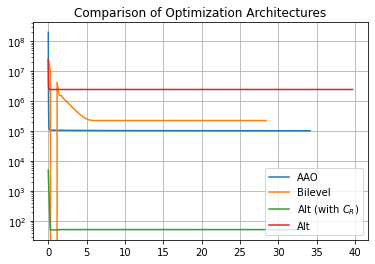

In [359]:
plt.plot(times_aao, aao_history, label="AAO")
plt.plot(times_bi, bi_history, label="Bilevel")
plt.plot(times_with, history_alt_with, label="Alt (with $C_R$)")
plt.plot(times_without, history_alt_without, label="Alt")
#plt.ylim(-1e7,2e7)
#plt.ylim(-1e7,1e6)
plt.yscale("log")
plt.grid()
plt.legend()
plt.title("Comparison of Optimization Architectures")
fig = plt.gcf()

In [360]:
fig.savefig('notional_comparison.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [382]:
tab = pd.DataFrame(columns = ["x_p", "x_a", "x_r", "x_s", "x_b", "x_c"])
tab.loc['aao'] = list(result_aao['x'])
tab.loc['bilevel'] = list(result_bi['x']) + list(args['xres'])
tab.loc['alt_without'] = list(xdes_without) + list(xres_without)
tab.loc['alt_with'] = list(xdes_with) + list(xres_with)

In [383]:
tab

,x_p,x_a,x_r,x_s,x_b,x_c
aao,0.909019,1.002389e-06,0.999420,0.909018,2.484163,2.129183
bilevel,0.955037,5.054167e-01,0.005453,0.449620,2.761836,13.102197
alt_without,0.984955,8.344999e-01,0.146386,0.150455,0.077405,20.000000
alt_with,0.832347,9.734858e-09,0.999370,0.832347,100.000000,20.000022


In [364]:
res_cost(xres_without,xdes_without, const)

2462096.8079811865

In [365]:
xres_without

array([ 0.0774055 , 19.99999985])

In [371]:
xdes_without

array([0.98495453, 0.83449988, 0.14638619, 0.15045465])

In [232]:
result_bi

 barrier_parameter: 0.00016000000000000007
 barrier_tolerance: 0.00016000000000000007
          cg_niter: 241
      cg_stop_cond: 4
            constr: [array([-2.22044605e-16]), array([0.12474944]), array([0.9456091 , 0.89115089, 0.00373458, 0.0544582 ])]
       constr_nfev: [159, 159, 0]
       constr_nhev: [0, 0, 0]
       constr_njev: [159, 159, 0]
    constr_penalty: 1.0
  constr_violation: 2.220446049250313e-16
    execution_time: 33.289212703704834
               fun: 251358.77860831958
              grad: array([-108781.7890625 ,  193282.22460938,  100616.78515625,
        108916.42578125])
               jac: [array([[ 1, -1,  0, -1]]), array([[ 0.        , -0.29584538, -1.        ,  0.        ]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]
   lagrangian_grad: array([ 8.40886790e+03,  8.46114191e+03, -8.38840984e-01, -5.22740099e+01])
           message: 'The maximum number of function evaluations is exceeded.'
       